In [2]:
# DATALOADER PARAMS
bs          = 4
nepochs     = 30
num_workers = 2

# PREPROCESS (Isotropic, PadResize)
# iso       = 3
# maxs      = [87, 90, 90]

iso       = 2
maxs      = [130, 134, 134]

# Train:Valid:Test = 60:20:20
train_pct, valid_pct = .60, .20

#train_pct, valid_pct = 100/335.0, 20/335.0

test_pct = 1.0 - train_pct - valid_pct

def pct2int(pct, tot=335): return int(pct * tot)
print(f"Train/Valid/Test: {train_pct:0.2f} (n={pct2int(train_pct)}), {valid_pct:0.2f} (n={pct2int(valid_pct)}), {test_pct:0.2f} (n={pct2int(test_pct)})")

Train/Valid/Test: 0.60 (n=201), 0.20 (n=67), 0.20 (n=67)


In [3]:
# CHECK HARDWARE 

import os
import torch

gpu_count = torch.cuda.device_count()
cpu_count = os.cpu_count()
print("#GPU = {0:d}, #CPU = {1:d}".format(gpu_count, cpu_count))

# clear cache
import gc
import torch

gc.collect()
torch.cuda.empty_cache()

# print GPU stats
import GPUtil as GPU
GPUs = GPU.getGPUs()
for gpu in GPUs:
    print("GPU {0:20s} RAM Free: {1:.0f}MB | Used: {2:.0f}MB | Util {3:3.0f}% | Total {4:.0f}MB".format(gpu.name, gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))

#GPU = 2, #CPU = 40
GPU Tesla V100-SXM2-16GB RAM Free: 16119MB | Used: 11MB | Util   0% | Total 16130MB
GPU Tesla V100-SXM2-16GB RAM Free: 16119MB | Used: 11MB | Util   0% | Total 16130MB


# Goal

Train hybrid OBELISK-NET/UNET. Tune batch size and presize HWD dimensions.
- Preprocess: Smooth, intensity norm (N4 bias, hist bin matching)
- Augmentations: flip, orientation, 10 deg
- Thanks to: OBELISK, FAIMED3D
    - https://github.com/mattiaspaul/OBELISK
    -  https://github.com/kbressem/faimed3d/blob/main/examples/3d_segmentation.md

# Paths

In [4]:
import os

# Paths to (1) code (2) data (3) saved models
code_src    = "/gpfs/home/gologr01"
data_src    = "/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata"
model_src   = "/gpfs/data/oermannlab/private_data/DeepPit/saved_models"

# UMich 
# code src: "/home/labcomputer/Desktop/Rachel"
# data src: "../../../../..//media/labcomputer/e33f6fe0-5ede-4be4-b1f2-5168b7903c7a/home/rachel/"

deepPit_src = f"{code_src}/DeepPit"
obelisk_src = f"{code_src}/OBELISK"
label_src   = f"{data_src}/samir_labels"
ABIDE_src   = f"{data_src}/ABIDE"

# print
print("Folders in data src: ", end=""); print(*os.listdir(data_src), sep=", ")
print("Folders in label src (data w labels): ", end=""); print(*os.listdir(label_src), sep=", ")
print("Folders in ABIDE src (data wo labels) ", end=""); print(*os.listdir(ABIDE_src), sep=", ")

Folders in data src: ICMB, ABVIB (1).zip, central.xnat.org, ADNI, PPMI, Oasis_long, samir_labels, ACRIN-FMISO-Brain, LGG-1p19qDeletion, REMBRANDT, AIBL, test.txt, CPTAC-GBM, ABIDE-ABIDE-top.txt, TCGA-GBM, TCGA-LGG, ABVIB, ABIDE, AIBL.zip
Folders in label src (data w labels): 50155-50212, 50313-50372, 50213-50312, 50373-50453, 50002-50153
Folders in ABIDE src (data wo labels) PAD, ABIDE_1, ABIDE


# Imports

In [9]:
# imports
from transforms import AddChannel, Iso, PadSz, MattAffineTfm, PiecewiseHistScaling
from helpers.metrics import dice_score, dice_loss, dice_ce_loss, log_cosh_dice_loss

# Utilities
import os
import sys
import time
import pickle
from pathlib import Path

# Input IO
import SimpleITK as sitk
import meshio

# Numpy and Pandas
import numpy as np
import pandas as pd
from pandas import DataFrame as DF

# Fastai + distributed training
from fastai import *
from fastai.torch_basics import *
from fastai.basics import *
from fastai.distributed import *

# PyTorch
from torchvision.models.video import r3d_18
from fastai.callback.all import SaveModelCallback
from torch import nn

# Obelisk
sys.path.append(deepPit_src)
sys.path.append(obelisk_src)

# OBELISK
from utils import *
from models import obelisk_visceral, obeliskhybrid_visceral

# 3D extension to FastAI
# from faimed3d.all import *

# Helper functions
from helpers.preprocess import get_data_dict_n4, paths2objs, folder2objs, seg2mask, mask2bbox, print_bbox, get_bbox_size, print_bbox_size
from helpers.general import sitk2np, np2sitk, print_sitk_info, round_tuple, lrange, lmap, get_roi_range, numbers2groups
from helpers.viz import viz_axis
from helpers.nyul_udupa import piecewise_hist

# Data

In [6]:
# Get data dict
data = {}
folders = os.listdir(label_src)
for folder in folders: data.update(get_data_dict_n4(f"{label_src}/{folder}"))

# Convert data dict => items (path to MR, path to Segm tensor)
items = list(data.values())

# Split train/valid/test split
train_idxs, test_idxs = RandomSplitter(valid_pct=test_pct)(items)
train_items = [items[i] for i in train_idxs]
test_items  = [items[i] for i in test_idxs]

train_idxs, valid_idxs = RandomSplitter(valid_pct=valid_pct)(train_items)
train_items = [items[i] for i in train_idxs]
valid_items = [items[i] for i in valid_idxs]

# print
print(f"Total {len(items)} items in dataset.")
print(f"Train: {len(train_items)} items.")
print(f"Valid: {len(valid_items)} items.")
print(f"Test: {len(test_items)} items.")

# Save test idxs

# file name
model_time = time.ctime() # 'Mon Oct 18 13:35:29 2010'
model_name = f"iso_{iso}mm_pad_{maxs[0]}_{maxs[1]}_{maxs[2]}_bs_{bs}_test_sz_{len(test_items)}_epochs_{nepochs}_time_{model_time}"
print(f"Model name: {model_name}")

# save test set indices
with open(f"{model_src}/{model_name}_test_items.pkl", 'wb') as f:
    pickle.dump(list(test_items), f)

Total 335 items in dataset.
Train: 215 items.
Valid: 53 items.
Test: 67 items.
Model name: iso_2mm_pad_130_134_134_bs_4_test_sz_67_epochs_30_time_Mon Jun 28 19:07:17 2021


# Dataloaders

In [10]:
# load standard scale
save_loc = f"{deepPit_src}/saved_metadata/"
standard_scale = torch.load(f"{save_loc}/nyul_udupa_standard_scale_335.pt")
percs          = torch.load(f"{save_loc}/nyul_udupa_percs_335.pt")

In [11]:
# time it
start = time.time()

# splits
#splits = RandomSplitter(seed=42)(subset)
#print(f"Training: {len(splits[0])}, Valid: {len(splits[1])}")

# tfms
item_tfms  = [Iso(2), PadSz(maxs), PiecewiseHistScaling(landmark_percs=percs, standard_scale=standard_scale)]
batch_tfms = [AddChannel(), MattAffineTfm(0.05)]

# tls
tls = TfmdLists(items, item_tfms, splits=(train_idxs, valid_idxs))

# dls
dls = tls.dataloaders(bs=bs, after_batch=batch_tfms, num_workers=num_workers)

# GPU
dls = dls.cuda()

# end timer
elapsed = time.time() - start
print(f"Elapsed time: {elapsed} s for {len(train_idxs) + len(valid_idxs)} items")

# test get one batch
b = dls.one_batch()
print(type(b), b[0].shape, b[1].shape)
print(len(dls.train), len(dls.valid))

Elapsed time: 0.4276247024536133 s for 268 items
<class 'tuple'> torch.Size([4, 1, 130, 134, 134]) torch.Size([4, 1, 130, 134, 134])
53 14


In [9]:
# test: viz 1 img before and after affine tfm
idx = 2
strength = 0.05

img_in, seg_in     = Pipeline(item_tfms)(items[idx])
b_img_in, b_seg_in = (img_in.unsqueeze(0), seg_in.unsqueeze(0))
img_out1, seg_out1 = AddChannel()((b_img_in, b_seg_in))
img_out2, seg_out2 = MattAffineTfm(strength=strength)((img_out1, seg_out1))

print(img_in.shape, b_img_in.shape, img_out1.shape, img_out2.shape, sep="\n")

# Viz

def viz_bbox(mr, seg):

    mr, seg = np.array(mr), np.array(seg)
    gt_bbox = mask2bbox(mr)
    
    # print bbox
    print("GT: "); print_bbox(*gt_bbox)

    bbox = gt_bbox
    
    axis0_len = bbox[1] - bbox[0]
    start_middle = bbox[0] + axis0_len//2 - 2
    end_middle = start_middle + 4
    
    # viz
    viz_axis(np_arr = mr, \
            bin_mask_arr   = seg,     color1 = "yellow",  alpha1=0.3, \
            #bin_mask_arr2  = pred_mk, color2 = "magenta", alpha2=0.3, \
            slices=lrange(start_middle, end_middle), fixed_axis=0, \
            axis_fn = np.rot90, \
            title   = "Axis 0", \

#             np_arr_b = mr, \
#             bin_mask_arr_b   = seg,     color1_b = "yellow",  alpha1_b=0.3, \
#             #bin_mask_arr2_b  = pred_mk, color2_b = "magenta", alpha2_b=0.3, \
#             slices_b = lrange(*bbox[2:4]), fixed_axis_b=1, \
#             title_b  = "Axis 1", \

#             np_arr_c = mr, \
#             bin_mask_arr_c   = seg,     color1_c = "yellow",  alpha1_c=0.3, \
#             #bin_mask_arr2_c  = pred_mk, color2_c = "magenta", alpha2_c=0.3, \
#             slices_c = lrange(*bbox[4:6]), fixed_axis_c=2, \
#             title_c = "Axis 2", \
  
        ncols = 5, hspace=0.3, fig_mult=2)

    

torch.Size([130, 134, 134])
torch.Size([1, 130, 134, 134])
torch.Size([1, 1, 130, 134, 134])
torch.Size([1, 1, 130, 134, 134])


GT: 
Bbox coords: (21, 7, 39) to (109, 121, 117). Size: 88, 114, 78.
Bounding box coord: from location (7, 39) of slice 21 to location (121, 117) of slice 109.


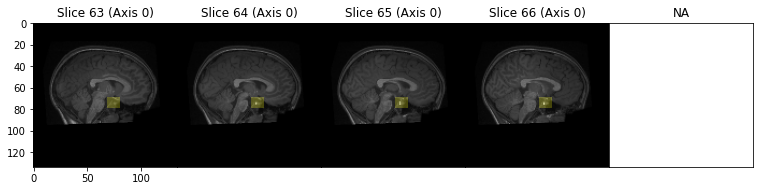

In [10]:
viz_bbox(img_out1.squeeze(), seg_out1.squeeze())

GT: 
Bbox coords: (21, 7, 39) to (109, 121, 117). Size: 88, 114, 78.
Bounding box coord: from location (7, 39) of slice 21 to location (121, 117) of slice 109.


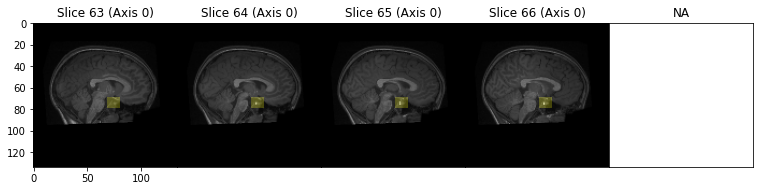

In [11]:
viz_bbox(img_out2.squeeze(), seg_out2.squeeze())

# Metric

Linear combination of Dice and Cross Entropy

In [14]:
# start = time.time()

# segs = torch.cat([tl[1] for tl in dls.train],0)
# print(segs.shape)

# elapsed = time.time() - start

# print(f"Elapsed time: {elapsed} s for {len(segs)} items")

In [15]:
# class_weight = torch.sqrt(1.0/(torch.bincount(segs.view(-1)).float()))
# class_weight = class_weight/class_weight.mean()
# class_weight[0] = 0.5
# np.set_printoptions(formatter={'float': '{: 0.2f}'.format})
# print('inv sqrt class_weight',class_weight.data.cpu().numpy())

In [16]:
from utils import my_ohem

In [17]:
# pos_weight = torch.load("saved_metadata/class_weights.pt")
# class_weights = [0, pos_weight]

# # inv
# class_weights [1.0/x for x in class_wei]
# my_criterion = my_ohem(.25,[0, pos_weight]) #.cuda())#0.25 

In [18]:
def obelisk_loss_fn(predict, target): return my_criterion(F.log_softmax(predict,dim=1),target)

In [19]:
# ipython nbconvert --to python  '6 - Dataloaders- NB - Simple-Copy1.ipynb'

# Learner

In [20]:
# clear cache
import gc
import torch

gc.collect()
torch.cuda.empty_cache()

# print GPU stats
import GPUtil as GPU
GPUs = GPU.getGPUs()
for gpu in GPUs:
    print("GPU {0:20s} RAM Free: {1:.0f}MB | Used: {2:.0f}MB | Util {3:3.0f}% | Total {4:.0f}MB".format(gpu.name, gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))

GPU Tesla V100-SXM2-16GB RAM Free: 11013MB | Used: 5117MB | Util  32% | Total 16130MB
GPU Tesla V100-SXM2-16GB RAM Free: 16119MB | Used: 11MB | Util   0% | Total 16130MB


In [21]:
# OBELISK-NET from github
from models import obelisk_visceral, obeliskhybrid_visceral

In [22]:
full_res = maxs

learn = Learner(dls=dls, \
                model=obeliskhybrid_visceral(num_labels=2, full_res=full_res), \
                loss_func= log_cosh_dice_loss, #loss, #DiceLoss(), #nn.CrossEntropyLoss(), \
                metrics = dice_score, \
                model_dir = model_src, \
                cbs = [SaveModelCallback(monitor='dice_score', fname=model_name, with_opt=True)])

# SaveModelCallback: model_dir = "./models", cbs = [SaveModelCallback(monitor='dice_score')]

# GPU
learn.model = learn.model.cuda()

#learn = learn.to_distributed(args.local_rank)


In [23]:
# # test:

# #dls.device = "cpu"

# start = time.time()

# x,y = dls.one_batch()
# #x,y = to_cpu(x), to_cpu(y)

# pred = learn.model(x)
# loss = learn.loss_func(pred, y)

# elapsed = time.time() - start

# print(f"Elapsed: {elapsed} s")
# print("Batch: x,y")
# print(type(x), x.shape, x.dtype, "\n", type(y), y.shape, y.dtype)

# print("Pred shape")
# print(type(pred), pred.shape, pred.dtype)

# print("Loss")
# print(loss)
# print(learn.loss_func)

# LR Finder

In [24]:
# learn.lr_find()

In [25]:
print("PRE learn.fit one cycle")
with learn.distrib_ctx():
    learn.fit_one_cycle(1, 3e-3, wd = 1e-4)

PRE learn.fit one cycle


epoch,train_loss,valid_loss,dice_score,time
0,0.426883,0.427382,0.246723,01:22


Better model found at epoch 0 with dice_score value: 0.24672286212444305.


In [26]:
print(f"unfreeze, learn {nepochs}")
learn.unfreeze()
with learn.distrib_ctx():
    learn.fit_one_cycle(nepochs, 3e-3, wd = 1e-4)

unfreeze, learn 30


epoch,train_loss,valid_loss,dice_score,time
0,0.422948,0.420150,0.097193,01:17
1,0.418967,0.418131,0.035945,01:17
2,0.390022,0.343451,0.609195,01:16
3,0.230295,0.228906,0.386022,01:15
4,0.123990,0.042624,0.746254,01:15
5,0.069994,0.034468,0.757484,01:18
6,0.049197,0.062268,0.654944,01:15
7,0.037891,0.059800,0.675097,01:16
8,0.032407,0.025846,0.777986,01:17
9,0.028001,0.021486,0.800481,01:17


Better model found at epoch 0 with dice_score value: 0.09719299525022507.
Better model found at epoch 2 with dice_score value: 0.6091952323913574.
Better model found at epoch 4 with dice_score value: 0.7462543249130249.
Better model found at epoch 5 with dice_score value: 0.7574840784072876.
Better model found at epoch 8 with dice_score value: 0.7779859900474548.
Better model found at epoch 9 with dice_score value: 0.8004812002182007.
Better model found at epoch 15 with dice_score value: 0.8202997446060181.
Better model found at epoch 19 with dice_score value: 0.822708785533905.
Better model found at epoch 21 with dice_score value: 0.8285341262817383.
Better model found at epoch 24 with dice_score value: 0.833476722240448.
Better model found at epoch 25 with dice_score value: 0.8351632356643677.


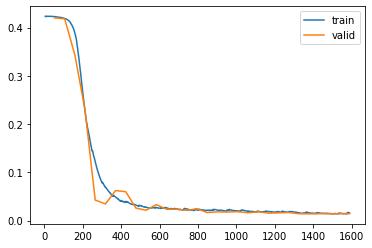

In [27]:
learn.recorder.plot_loss()

In [28]:
@patch
@delegates(subplots)
def plot_metrics(self: Recorder, nrows=None, ncols=None, figsize=None, **kwargs):
    metrics = np.stack(self.values)
    names = self.metric_names[1:-1]
    n = len(names) - 1
    if nrows is None and ncols is None:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n / nrows))
    elif nrows is None: nrows = int(np.ceil(n / ncols))
    elif ncols is None: ncols = int(np.ceil(n / nrows))
    figsize = figsize or (ncols * 6, nrows * 4)
    fig, axs = subplots(nrows, ncols, figsize=figsize, **kwargs)
    axs = [ax if i < n else ax.set_axis_off() for i, ax in enumerate(axs.flatten())][:n]
    for i, (name, ax) in enumerate(zip(names, [axs[0]] + axs)):
        ax.plot(metrics[:, i], color='#1f77b4' if i == 0 else '#ff7f0e', label='valid' if i > 0 else 'train')
        ax.set_title(name if i > 1 else 'losses')
        ax.legend(loc='best')
    plt.show()

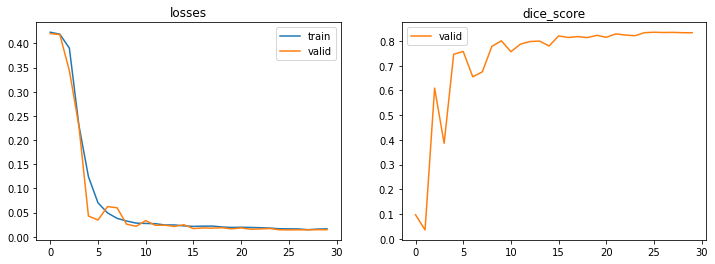

In [29]:
learn.recorder.plot_metrics()

In [ ]:
with learn.distrib_ctx():
    learn.fit_one_cycle(nepochs, 3e-3, wd = 1e-4)

# Affine Tfm

In [ ]:
# from OBELISK mattiaspaul

def augmentAffine(img_in, seg_in, strength=0.05):
    """
    3D affine augmentation on image and segmentation mini-batch on GPU.
    (affine transf. is centered: trilinear interpolation and zero-padding used for sampling)
    :input: img_in batch (torch.cuda.FloatTensor), seg_in batch (torch.cuda.LongTensor)
    :return: augmented BxCxTxHxW image batch (torch.cuda.FloatTensor), augmented BxTxHxW seg batch (torch.cuda.LongTensor)
    """
    B,C,D,H,W = img_in.size()
    affine_matrix = (torch.eye(3,4).unsqueeze(0) + torch.randn(B, 3, 4) * strength).to(img_in.device)

    meshgrid = F.affine_grid(affine_matrix,torch.Size((B,1,D,H,W)))

    img_out = F.grid_sample(img_in, meshgrid,padding_mode='border')
    seg_out = F.grid_sample(seg_in.float(), meshgrid, mode='nearest').long()

    return img_out, seg_out


In [ ]:
torch.eye(3,4).unsqueeze(0)

In [ ]:
torch.randn(1, 3, 4)*0.05

In [ ]:
# batch
b_img_in, b_seg_in = dls.one_batch()
#b_seg_in = b_seg_in.squeeze(1)
print(b_img_in.shape, b_seg_in.shape)

In [ ]:
b_img_out, b_seg_out = augmentAffine(b_img_in, b_seg_in)
print(b_img_out.shape, b_seg_out.shape)

idx = 0
img_in, seg_in, img_out, seg_out = [arr[idx].squeeze(0) for arr in (b_img_in, b_seg_in, b_img_out, b_seg_out)]
print(img_in.shape, seg_in.shape, img_out.shape, seg_out.shape)
                                                        

In [ ]:
# Viz

def viz_bbox(mr, seg):

    mr, seg = np.array(mr), np.array(seg)
    gt_bbox = mask2bbox(mr)
    
    # print bbox
    print("GT: "); print_bbox(*gt_bbox)

    bbox = gt_bbox
    
    # viz
    viz_axis(np_arr = mr, \
            bin_mask_arr   = seg,     color1 = "yellow",  alpha1=0.3, \
            #bin_mask_arr2  = pred_mk, color2 = "magenta", alpha2=0.3, \
            slices=lrange(*bbox[0:2]), fixed_axis=0, \
            axis_fn = np.rot90, \
            title   = "Axis 0", \

#             np_arr_b = mr, \
#             bin_mask_arr_b   = seg,     color1_b = "yellow",  alpha1_b=0.3, \
#             #bin_mask_arr2_b  = pred_mk, color2_b = "magenta", alpha2_b=0.3, \
#             slices_b = lrange(*bbox[2:4]), fixed_axis_b=1, \
#             title_b  = "Axis 1", \

#             np_arr_c = mr, \
#             bin_mask_arr_c   = seg,     color1_c = "yellow",  alpha1_c=0.3, \
#             #bin_mask_arr2_c  = pred_mk, color2_c = "magenta", alpha2_c=0.3, \
#             slices_c = lrange(*bbox[4:6]), fixed_axis_c=2, \
#             title_c = "Axis 2", \
  
        ncols = 5, hspace=0.3, fig_mult=2)


In [ ]:
viz_bbox(img_in.cpu(), seg_in.cpu())

In [ ]:
# learn.save('iso_3mm_pad_87_90_90_subset_50_epochs_50')

In [ ]:
viz_bbox(img_out.cpu(), seg_out.cpu())

In [ ]:
# learn.lr_find()

In [ ]:
# print("unfreeze, learn 50")
# learn.unfreeze()
# learn.fit_one_cycle(50, 1e-3, wd = 1e-4)

In [ ]:
# testmask = torch.tensor([[[False, False, False], [False, False, False], [True, True, True]],
#                        [[False, False, False], [False, False, True], [True, True, True]],
#                        [[False, False, False], [False, False, False], [False, False, False]]])
# testmask

In [ ]:
# testmaskN = np.array(testmask)
# testmaskN

In [ ]:
# maskT = testmask.type(torch.BoolTensor)

# iT = torch.any(maskT, dim=(1,2))
# jT = torch.any(maskT, dim=(0,2))
# kT = torch.any(maskT, dim=(0,1))

# iminT, imaxT = torch.where(iT)[0][[0, -1]]
# jminT, jmaxT = torch.where(jT)[0][[0, -1]]
# kminT, kmaxT = torch.where(kT)[0][[0, -1]]

In [ ]:
# maskN = np.array(testmask).astype(bool)
    
# iN = np.any(maskN, axis=(1, 2))
# jN = np.any(maskN, axis=(0, 2))
# kN = np.any(maskN, axis=(0, 1))

# iminN, imaxN = np.where(iN)[0][[0, -1]]
# jminN, jmaxN = np.where(jN)[0][[0, -1]]
# kminN, kmaxN = np.where(kN)[0][[0, -1]]

In [ ]:
# maskT.shape, maskN.shape

In [ ]:
# print(iT)
# print(jT)
# print(kT)
# print([x for x in (iminT, imaxT, jminT, jmaxT, kminT, kmaxT)])

In [ ]:
# print(iN)
# print(jN)
# print(kN)
# print([int(x) for x in (iminN, imaxN, jminN, jmaxN, kminN, kmaxN)])

In [ ]:
#     def torch_mask2bbox(mask):
#         mask = mask.type(torch.BoolTensor)

#         i = torch.any(mask, dim=0)
#         j = torch.any(mask, dim=1)
#         k = torch.any(mask, dim=2)

#         imin, imax = torch.where(i)[0][[0, -1]]
#         jmin, jmax = torch.where(j)[0][[0, -1]]
#         kmin, kmax = torch.where(k)[0][[0, -1]]

#         # inclusive idxs
#         return imin, imax+1, jmin, jmax+1, kmin, kmax+1

In [ ]:
# with open(f"{model_src}/{model_name}_test_items.pkl", 'rb') as f:
#     check_test_items = pickle.load(f)
#     print(check_test_items==test_items)
#     print(check_test_items[0])

In [ ]:
# unique, for rapid prototyping

# MR files: unique sz, sp, dir
with open(f'{deepPit_src}/saved_metadata/unique_sz_sp_dir.pkl', 'rb') as f:
    unique = pickle.load(f)
    
# Create (MR path, Segm path) item from MR path
def get_folder_name(s):
    start = s.index("samir_labels/")
    s = s[start + len("samir_labels/50373-50453/"):]
    return s[0:s.index("/")]

def change_prefix(s):
    start = s.index("samir_labels/")
    return f"{label_src}/{s[start+len('samir_labels/'):]}"

# get unique
unique = [(change_prefix(mr), data[get_folder_name(mr)][1]) for mr in unique]

# Transforms

1. Isotropic 3mm or Resize to 50x50x50 dimensions
2. Crop/Pad to common dimensions

In [ ]:
# test

tfms = [Iso(2)]
tls = TfmdLists(unique, tfms)

start = time.time()
iso_szs = [mr.shape for mr,mk in tls]
elapsed = time.time() - start

print(f"Elapsed: {elapsed} s for {len(unique)} items.")

In [ ]:
start = time.time()
iso_szs = [mr.shape for mr,mk in tls]
elapsed = time.time() - start

print(f"Elapsed: {elapsed} s for {len(unique)} items.")

In [ ]:
print(*[f"{get_folder_name(mr)}: {tuple(sz)}" for (mr,mk),sz in zip(unique, iso_szs)], sep="\n")

In [ ]:
maxs = [int(x) for x in torch.max(torch.tensor(iso_szs), dim=0).values]
print("Maxs: ", maxs)

# Crop

In [ ]:
# # test
# iso_items = list(tls[0:2])

# # tfms
# pad_tfms = [PadSz(maxs)]

# # tls
# pad_tls = TfmdLists(iso_items, pad_tfms)

# pad_tls[0][0].shape, pad_tls[1][0].shape